In [19]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from decomposition import DecompositionLayer
torch.set_num_threads(9)

class MyDataset(TensorDataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        return x

    def __len__(self):
        return len(self.data) - self.window

In [20]:
input_size = 15
pred = input_size
learning_rate = 0.0001

data_size  = 4000
step = 10
m = 10 #на сколько шагов предсказать
data_set = 9000
model_name = "update_model_v1"

In [21]:
class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        #print(x_trend.shape)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

In [22]:
class DLinearModel(nn.Module):
    def __init__(self, input_size):
        super(DLinearModel, self).__init__()
        self.linear_seasonal = nn.Linear(input_size, 1)
        self.linear_trend = nn.Linear(input_size, 1)
        self.decomposition = DecompositionLayer(input_size)
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, context):
        seasonal, trend = self.decomposition(context)
        #print(seasonal, trend)
        seasonal_output = self.linear_seasonal(seasonal.reshape(1, 1, -1))
        trend_output = self.linear_trend(trend.reshape(1, 1, -1))
        
        return seasonal_output + trend_output


def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        print("Epoch = ", epoch)
        for X in dataloader:
            
            optimizer.zero_grad()
            output = model.forward(X)
            loss = criterion(output, X)
            loss.backward()
            optimizer.step()


In [23]:

data = pd.read_csv('ETTh1.csv')  
X = torch.tensor(data['HUFL'].values[:data_size:step], dtype=torch.float32).view(-1, 1)
x = pd.read_csv("ETTh1.csv").HUFL

In [24]:
model = DLinearModel(input_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)


window_size = input_size  # Размер окна для rolling window forecasting
#переписать

dataset = MyDataset(X, window_size)

#print(x.rolling(window_size))

dataloader = DataLoader(dataset)#, shuffle=True)

In [25]:
len(dataloader)

385

In [26]:
#train_model(model, dataloader, criterion, optimizer)


In [27]:
#torch.save(model.state_dict(), model_name)

In [28]:
model.load_state_dict(torch.load(model_name))
model.eval()

DLinearModel(
  (linear_seasonal): Linear(in_features=15, out_features=1, bias=True)
  (linear_trend): Linear(in_features=15, out_features=1, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(15,), stride=(1,), padding=(0,))
  )
)

In [29]:
model.parameters

<bound method Module.parameters of DLinearModel(
  (linear_seasonal): Linear(in_features=15, out_features=1, bias=True)
  (linear_trend): Linear(in_features=15, out_features=1, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(15,), stride=(1,), padding=(0,))
  )
)>

In [30]:
def predict_future_values(model, X_f, window_size, m):
    #predicted_values = initial_values.clone().detach().view(-1).tolist()
    predicted_values = []
    
    for i in range(m):
        
        
        #проверить что модель принимает нужный набор значений
        #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        
        prediction = model(X_f)

        
        predicted_values.append(prediction.tolist()[-1][-1][-1])
        if(window_size > i):
            
            X_f = torch.tensor(data['HUFL'].values[data_size-window_size+i+1::step] + predicted_values, dtype=torch.float32).reshape(1, 1, -1)
        else:
            X_f = torch.tensor(predicted_values, dtype=torch.float32).reshape(1, 1, -1)
            
        

    return predicted_values

In [31]:
initial_values = torch.cat([X[-input_size:]]).reshape(1, 1, -1)

pred = input_size
X_f = torch.tensor(data['HUFL'].values[data_set-pred:data_set-pred+pred*step:step], dtype=torch.float32).view(-1, 1)
print(X_f)
dataset_f = MyDataset(X_f, pred)
print(dataset_f.data)
#print(x.rolling(window_size))

dataloader_f = DataLoader(dataset_f)#, shuffle=True)

X_f


tensor([[  5.8270],
        [  7.1000],
        [  9.5780],
        [ -7.5690],
        [  9.9800],
        [ -4.2870],
        [ 15.8740],
        [  9.3100],
        [  1.8750],
        [ 14.9370],
        [-10.2480],
        [ 13.8650],
        [  2.0760],
        [ 11.6550],
        [ 15.4720]])
tensor([[  5.8270],
        [  7.1000],
        [  9.5780],
        [ -7.5690],
        [  9.9800],
        [ -4.2870],
        [ 15.8740],
        [  9.3100],
        [  1.8750],
        [ 14.9370],
        [-10.2480],
        [ 13.8650],
        [  2.0760],
        [ 11.6550],
        [ 15.4720]])


tensor([[  5.8270],
        [  7.1000],
        [  9.5780],
        [ -7.5690],
        [  9.9800],
        [ -4.2870],
        [ 15.8740],
        [  9.3100],
        [  1.8750],
        [ 14.9370],
        [-10.2480],
        [ 13.8650],
        [  2.0760],
        [ 11.6550],
        [ 15.4720]])

In [32]:
X_t = X_f.tolist()
X_t

[[5.827000141143799],
 [7.099999904632568],
 [9.57800006866455],
 [-7.568999767303467],
 [9.979999542236328],
 [-4.2870001792907715],
 [15.87399959564209],
 [9.3100004196167],
 [1.875],
 [14.937000274658203],
 [-10.248000144958496],
 [13.864999771118164],
 [2.0759999752044678],
 [11.654999732971191],
 [15.472000122070312]]

In [33]:

predicted_values = []



for i in range(m):
    
    
    #проверить что модель принимает нужный набор значений
    #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
    # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
    
    
    
    
    X = torch.tensor([X_t])
    print(X)
    prediction = model(X)
    predicted_values.append(prediction.tolist()[-1][-1][-1])
    X_next = prediction.tolist()[-1][-1]
    
    X_t.append(X_next)
    X_t = X_t[1:]
    dataset_f = MyDataset(X_t, window_size)
        
    


future_predictions = predicted_values

tensor([[[  5.8270],
         [  7.1000],
         [  9.5780],
         [ -7.5690],
         [  9.9800],
         [ -4.2870],
         [ 15.8740],
         [  9.3100],
         [  1.8750],
         [ 14.9370],
         [-10.2480],
         [ 13.8650],
         [  2.0760],
         [ 11.6550],
         [ 15.4720]]])
tensor([[[  7.1000],
         [  9.5780],
         [ -7.5690],
         [  9.9800],
         [ -4.2870],
         [ 15.8740],
         [  9.3100],
         [  1.8750],
         [ 14.9370],
         [-10.2480],
         [ 13.8650],
         [  2.0760],
         [ 11.6550],
         [ 15.4720],
         [  5.9928]]])
tensor([[[  9.5780],
         [ -7.5690],
         [  9.9800],
         [ -4.2870],
         [ 15.8740],
         [  9.3100],
         [  1.8750],
         [ 14.9370],
         [-10.2480],
         [ 13.8650],
         [  2.0760],
         [ 11.6550],
         [ 15.4720],
         [  5.9928],
         [  5.8748]]])
tensor([[[ -7.5690],
         [  9.9800],
       

In [34]:
future_predictions

[5.992799758911133,
 5.874821186065674,
 6.296329498291016,
 5.763010025024414,
 6.913690567016602,
 6.563852787017822,
 7.033273696899414,
 6.857858657836914,
 6.337687015533447,
 6.970926761627197]

In [35]:
len(future_predictions)

10

Future Predictions: [5.992799758911133, 5.874821186065674, 6.296329498291016, 5.763010025024414, 6.913690567016602, 6.563852787017822, 7.033273696899414, 6.857858657836914, 6.337687015533447, 6.970926761627197]
10


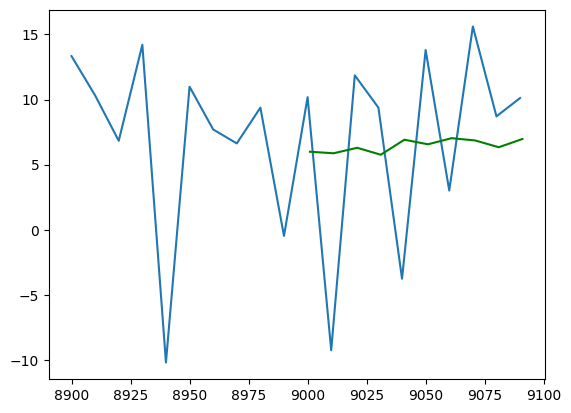

In [36]:
print("Future Predictions:", future_predictions)
time = [data_set-m*step+i*step for i in range(2*m)]
print(m)
plt.plot(time, data['HUFL'].values[data_set-m*step:data_set+(m)*step:step])
#plt.plot(, )
pred = data['HUFL'].values[data_set-1]
time = [data_set+1+i*step for i in range(m)]

    
plt.plot(time, future_predictions, 'g-')

plt.show()



